# Baseline 2:

Staged Least Squares Instrumental Variables Regression using Cornelia's Medical Data

- Using year, month, county as fixed effects. But interact year_trend * month_county.
- Include control diagnoses.

---
### Step 1: Import packages

In [15]:
# optional. I'm getting annoying warnings that I just want to ignore:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# basics
import pandas as pd 
import numpy as np
import os 
import re
from datetime import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
import requests
import urllib

# plotting
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import plotly.express as px
import seaborn as sns

# modeling
from patsy import dmatrices
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.sandbox.regression.gmm import IV2SLS
from statsmodels.stats.anova import anova_lm

import patsy
import sklearn.preprocessing as sklp
import statsmodels.api as sm

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

---
### Step 2: Define working directories

In [21]:
# in_dir_sc = 'C:/Users/cilin/Research/CA_hospitals_capstone/data/'
# in_dir_h = 'C:/Users/cilin/Research/CA_hospitals_capstone/output/'


in_dir_sc = '/Users/michelle/MIDS/210 Capstone/data/'
in_dir_h = '/Users/michelle/MIDS/210 Capstone/output/'

---
### Step 3: Define functions

In [17]:
def fit_ols(df, outcome, predictor):
    ''''''
    # drop if outcome is nan
    # temp = df[~df[outcome].isna()]
    # temp.reset_index(drop=True, inplace=True)

    # create FE and interactions between FE and continous vars
    f = outcome + " ~ county + month + year_trend * C(county_month)"
    y, X_fe = patsy.dmatrices(f, temp, return_type="dataframe")
    
    # X = temp[['pm25']]
    X = temp[[predictor]]
    
    # concat
    X = pd.concat([X, X_fe], axis=1)

    # fit model
    model_a = sm.OLS(y, X).fit(
        cov_type='cluster',
        cov_kwds={'groups':temp['county']},
        use_t=True
    )
    
    # display estimates
    print('Outcome: ', outcome)
    print('-------------------------------------')
    display(pd.concat(
        [
            pd.DataFrame(model_a.params).reset_index(drop=False).rename(columns={"index":"variable", 0:"coef"}).iloc[0:2,:],
            pd.DataFrame(model_a.bse).reset_index(drop=False).rename(columns={"index":"variable", 0:"std err"}).iloc[0:2,1:2],
            model_a.conf_int(alpha=0.05, cols=None).reset_index(drop=True).rename(columns={0:"[0.025", 1:"0.975]"}).iloc[0:2,:]
        ],
        axis=1
    ))

In [18]:
def fit_1st_stage(df, pm_col, instr_col):
    ''' First stage to check whether wfeI is a strong instrument for pm25I
    '''
    
    temp = df.copy()

    # create FE and interactions between FE and continous vars
    f = pm_col + " ~ county + month + year_trend * C(county_month)"
    y, X_fe = patsy.dmatrices(f, temp, return_type="dataframe")
    
    X = temp[[instr_col]]
    
    # concat
    X = pd.concat([X, X_fe], axis=1)

    # fit model
    fit_1st_stage = sm.OLS(y, X).fit(
        cov_type='cluster',
        cov_kwds={'groups':temp['county']},
        use_t=True
    )
    
    # display estimates
    print('Outcome: ', pm_col)
    print('-------------------------------------')
    display(pd.concat(
        [
            pd.DataFrame(fit_1st_stage.params).reset_index(drop=False).rename(columns={"index":"variable", 0:"coef"}).iloc[0:2,:],
            pd.DataFrame(fit_1st_stage.bse).reset_index(drop=False).rename(columns={"index":"variable", 0:"std err"}).iloc[0:2,1:2],
            fit_1st_stage.conf_int(alpha=0.05, cols=None).reset_index(drop=True).rename(columns={0:"[0.025", 1:"0.975]"}).iloc[0:2,:]
        ],
        axis=1
    ))
    
    # save pm25I_hat
    temp[pm_col+'_hat'] = fit_1st_stage.get_prediction(X).summary_frame()['mean']

    return temp

In [19]:
def fit_2sls(df, outcome, independent_var_name='pm25_hat'):
    ''''''
    # drop if outcome is nan
    temp = df[~df[outcome].isna()]
    temp.reset_index(drop=True, inplace=True)

    # create FE and interactions between FE and continous vars
    f = outcome + " ~ county + month + year_trend * C(county_month)"
    y, X_fe = patsy.dmatrices(f, temp, return_type="dataframe")
    
    #X = temp[['pm25_hat']]
    X = temp[[independent_var_name]]
    
    # concat
    X = pd.concat([X, X_fe], axis=1)

    # fit model
    model_a = sm.OLS(y, X).fit(
        cov_type='cluster',
        cov_kwds={'groups':temp['county']},
        use_t=True
    )
    
    # display estimates
    print('Outcome: ', outcome)
    print('-------------------------------------')
    display(pd.concat(
        [
            pd.DataFrame(model_a.params).reset_index(drop=False).rename(columns={"index":"variable", 0:"coef"}).iloc[0:2,:],
            pd.DataFrame(model_a.bse).reset_index(drop=False).rename(columns={"index":"variable", 0:"std err"}).iloc[0:2,1:2],
            model_a.conf_int(alpha=0.05, cols=None).reset_index(drop=True).rename(columns={0:"[0.025", 1:"0.975]"}).iloc[0:2,:]
        ],
        axis=1
    ))

---
### Step 4: Read and clean data

#### Generate rolling windows on dataframe (lead)

In [124]:
def roll_selected_cols(df, cols_to_roll:list = ['Izmy_v1_unnormed'\
    ,'Izmy_v2_nodist_unnormed' \
    ,'Izmy_v3_normed_D_and_TPY' \
    ,'Izmy_v4_nodist_normed_TPY' \
    ,'Izmy_v5_all_normed']
    ,rolling_periods:list = [6]):

    """Generates rolling averages for the input variables over the input time periods.
    Inputs: df (pd dataframe): contains the data on a y-m level
            cols_to_roll (list): list of columns to generate rolling avgs--must be in df
            rolling_periods (list): list of time windows (in months) to roll over
            
    Outputs: df: Pandas dataframe containing the new columns
             all_cols: list of list containing the new columns, separated by input type"""
    
    df_int = df.copy().sort_values(['school_zip', 'year_month'])
    
    all_cols_int = []

    # Roll each variable
    for col_index in range(len(cols_to_roll)):
        new_cols = []

        col_to_roll = cols_to_roll[col_index]
        rolling_periods = rolling_periods

        for period in rolling_periods:
            df_int[f'{col_to_roll}_r{period}'] = df_int.groupby('school_zip')[col_to_roll]\
                .apply(lambda x: x.rolling(window=period, min_periods=period, closed='left').mean())
            
            new_cols.append(col_to_roll + "_r" + str(period))

        all_cols_int.append([col_to_roll] + new_cols)
        
    return df_int, all_cols_int



In [27]:
# non-medical data
for file in os.listdir(in_dir_sc):
    if file.startswith('modeling'):
        # read in our modeling data
        df_sc = pd.read_csv(os.path.join(in_dir_sc, file))

# add key to df
df_sc['patzip_year_month'] = df_sc.school_zip.astype(str) + '-' + df_sc.year.astype(str) + '-' + df_sc.month.astype(str)

# add instrumental variables rolling things here - looking at past data, so need 2000-2002 for previous avgs
df_sc, df_sc_int = roll_selected_cols(roll_selected_cols)

# drop if year >=2018
df_sc = df_sc[df_sc.year.le(2017)]

# print shape of data
print('Shape of data ', df_sc.shape)
df_sc.head(2)



Shape of data  (262674, 141)


,Unnamed: 0,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_speed,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,ps_pm25_tpy_top_5,school_to_ps_geod_dist_m_top_5,avg_wspd_top_5,avg_u,avg_v,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed,schools,patzip_year_month
32223,32223,2002-01-01,90001,Los Angeles,Los Angeles County,25.950000,44.728889,43.703333,6104.0,3152.0,2952.0,6402.0,3247.0,3155.0,5548.0,2833.0,2715.0,5176.0,2644.0,2532.0,23230.0,11876.0,11354.0,55007.0,27550.0,27457.0,14.241154,3854.812685,-90.196586,0.946478,-154.458522,-154.458522,64.261936,64.261936,0.946478,64.261936,1.389537,0.000000,0.946478,20914.811067,2417758.0,43.953642,13.055556,13.533333,9,24.25,23.711111,21.916667,21.534722,21.597222,2.130476,1.409722,0.674301,0.182174,28.900000,2002,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2002-01,98.489179,10.899675,4588.668683,1.613005,-0.156038,-0.43018,1576.746029,6.524624e+06,84143.666276,1938.337589,24.095761,9.0,90001-2002-1
32224,32224,2002-01-01,90002,Los Angeles,Los Angeles County,25.783333,33.858889,29.690000,4899.0,2507.0,2392.0,5511.0,2793.0,2718.0,5069.0,2557.0,2512.0,4510.0,2261.0,2249.0,19989.0,10118.0,9871.0,45912.0,22218.0,23694.0,6.649500,2734.278190,-75.730039,0.946478,-154.458522,-154.458522,78.728483,78.728483,0.946478,78.728483,1.193386,0.222222,0.946478,20902.246991,1751715.0,38.153751,13.100000,14.600000,9,24.10,23.436111,21.7

In [30]:
# medical data
df_h = pd.DataFrame()
df_h['patzip_year_month'] = df_sc.patzip_year_month.unique()

for file in os.listdir(in_dir_h):
    # read in cornelia's healthcare data
    temp = pd.read_csv(os.path.join(in_dir_h, file)).iloc[:,1:]
    # rename number_of_visits column
    temp.rename(
        columns={'number_of_visits':'visits_'+file.split('.')[0]},
        inplace=True
    )

    # merge to df_h
    df_h = df_h.merge(
        temp[['patzip_year_month', 'visits_'+file.split('.')[0]]],
        on='patzip_year_month',
        how='left'
    )

# Filter out 2018 data bc it's all nulls 
# if year > 2017, drop
df_h['year_h'] = df_h.patzip_year_month.str.split('-').str[1]
df_h = df_h[df_h.year_h.le('2017')]
df_h.drop(columns='year_h', inplace=True)

# print shape of data
print('Shape of data ', df_h.shape)
df_h[~df_h.visits_resp_cardio.isna()].head(2)

Shape of data  (262674, 6)


,patzip_year_month,visits_hematopoietic_cancers,visits_injuries_accidents,visits_type_1_diabetes,visits_pediatric_vasculitis,visits_resp_cardio
165,91214-2002-1,NaN,NaN,NaN,NaN,112.0
172,91311-2002-1,NaN,NaN,NaN,NaN,115.0


In [31]:
df_h.columns

Index(['patzip_year_month', 'visits_hematopoietic_cancers',
       'visits_injuries_accidents', 'visits_type_1_diabetes',
       'visits_pediatric_vasculitis', 'visits_resp_cardio'],
      dtype='object')

---
### Step 5: Data preprocessing

#### Merge 2 datasets

In [32]:
# merge df_h to df_sc
df_all = df_sc.merge(
    df_h,
    on='patzip_year_month',
    how='left'
)

# print shape of data
print('Shape of data ', df_all.shape)
df_all.head(2)

# Shape of data  (294897, 164) <-- old one

Shape of data  (262674, 146)


,Unnamed: 0,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_speed,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,ps_pm25_tpy_top_5,school_to_ps_geod_dist_m_top_5,avg_wspd_top_5,avg_u,avg_v,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed,schools,patzip_year_month,visits_hematopoietic_cancers,visits_injuries_accidents,visits_type_1_diabetes,visits_pediatric_vasculitis,visits_resp_cardio
0,32223,2002-01-01,90001,Los Angeles,Los Angeles County,25.950000,44.728889,43.703333,6104.0,3152.0,2952.0,6402.0,3247.0,3155.0,5548.0,2833.0,2715.0,5176.0,2644.0,2532.0,23230.0,11876.0,11354.0,55007.0,27550.0,27457.0,14.241154,3854.812685,-90.196586,0.946478,-154.458522,-154.458522,64.261936,64.261936,0.946478,64.261936,1.389537,0.000000,0.946478,20914.811067,2417758.0,43.953642,13.055556,13.533333,9,24.25,23.711111,21.916667,21.534722,21.597222,2.130476,1.409722,0.674301,0.182174,28.900000,2002,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2002-01,98.489179,10.899675,4588.668683,1.613005,-0.156038,-0.43018,1576.746029,6.524624e+06,84143.666276,1938.337589,24.095761,9.0,90001-2002-1,NaN,NaN,NaN,NaN,NaN
1,32224,2002-01-01,90002,Los Angeles,Los Angeles County,25.783333,33.858889,29.690000,4899.0,2507.0,2392.0,5511.0,2793.0,2718.0,5069.0,2557.0,2512.0,4510.0,2261.0,2249.0,19989.0,10118.0,9871.0,45912.0,22218.0,23694.0,6.649500,2734.278190,-75.730039,0.946478,-154.458522,-154.458522,78.7

Shape of data  (262674, 153)


,Unnamed: 0,year_month,school_zip,county,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_speed,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,ps_pm25_tpy_top_5,school_to_ps_geod_dist_m_top_5,avg_wspd_top_5,avg_u,avg_v,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed,schools,patzip_year_month,visits_hematopoietic_cancers,visits_injuries_accidents,visits_type_1_diabetes,visits_pediatric_vasculitis,visits_resp_cardio,y_visits_hematopoietic_cancers,y_visits_injuries_accidents,y_visits_type_1_diabetes,y_visits_pediatric_vasculitis,y_visits_resp_cardio,year_trend,county_month
0,32223,2002-01-01,90001,Los Angeles,Los Angeles County,25.950000,44.728889,43.703333,6104.0,3152.0,2952.0,6402.0,3247.0,3155.0,5548.0,2833.0,2715.0,5176.0,2644.0,2532.0,23230.0,11876.0,11354.0,55007.0,27550.0,27457.0,14.241154,3854.812685,-90.196586,0.946478,-154.458522,-154.458522,64.261936,64.261936,0.946478,64.261936,1.389537,0.000000,0.946478,20914.811067,2417758.0,43.953642,13.055556,13.533333,9,24.25,23.711111,21.916667,21.534722,21.597222,2.130476,1.409722,0.674301,0.182174,28.900000,2002,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2002-01,98.489179,10.899675,4588.668683,1.613005,-0.156038,-0.43018,1576.746029,6.524624e+06,84143.666276,1938.337589,24.095761,9.0,90001-2002-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Los Angeles_1
1,32224,2002-01-01,90002,Los Angeles,Los Angeles County,25.783333,33.858889,29.690000,4899.0,2507.0,2

#### Fill in nulls conditionally

* the problem: for each health outcome, we want to fill in the nulls for a zipcode with 0's only if that row occurred after the first non-zero/not null visit in that zipcode for that health outcome. Keep them as nulls otherwise.
* So basically a zipcode will keep the nulls if they're on a date before the first visit seen for that health outcome, nulls will become 0 after the first visit seen for that health outcome.

In [63]:
df_test = df_all[['year_month', 'school_zip', 'year', 'month', 'visits_hematopoietic_cancers', 'visits_injuries_accidents', 'visits_type_1_diabetes', 'visits_pediatric_vasculitis', 'visits_resp_cardio']]

In [79]:
df_test.head(1)

,year_month,school_zip,year,month,visits_hematopoietic_cancers,visits_injuries_accidents,visits_type_1_diabetes,visits_pediatric_vasculitis,visits_resp_cardio
0,2002-01-01,90001,2002,1,NaN,NaN,NaN,NaN,NaN


In [77]:
df_grouped_schools
df_grouped_schools.first()

year  month  visits_hematopoietic_cancers  \
year_month school_zip                                              
2002-01-01 90001       2002      1                           NaN   
           90002       2002      1                           NaN   
           90003       2002      1                           NaN   
           90004       2002      1                           NaN   
           90006       2002      1                           NaN   
...                     ...    ...                           ...   
2017-12-01 96145       2017     12                           NaN   
           96146       2017     12                           NaN   
           96150       2017     12                           NaN   
           96161       2017     12                           NaN   
           97635       2017     12                           NaN   

                       visits_injuries_accidents  visits_type_1_diabetes  \
year_month school_zip                                                      
2002-01-01 90001                             NaN                     NaN   
           90002                             NaN                     NaN   
           90003                             NaN                     NaN   
           90004                             NaN                     NaN   
           90006                             NaN                     NaN   
...                                          ...                     ...   
2017-12-01 96145                           112.0                    17.0   
           96146                           112.0                     NaN   
           96150                             NaN                     NaN   
           96161                           138.0                     NaN   
           97635                             NaN                     NaN   

                       visits_pediatric_vasculitis  visits_resp_cardio  
year_month school_zip                                                   
2002-01-01 90001                               NaN                 NaN  
           90002                               NaN                 NaN  
           90003                               NaN                 NaN  
           90004                               NaN                 NaN  
           90006                               NaN                 NaN  
...                                            ...                 ...  
2017-12-01 96145                              17.0               116.0  
           96146                               NaN                 NaN  
           96150                               NaN                 NaN  
           96161                               NaN               135.0  
           97635                               NaN                 NaN  

[262674 rows x 7 columns]

In [128]:
df_grouped_schools = df_test.groupby(['school_zip', 'year_month']).tail(1)
df_grouped_schools
# #df_grouped_schools.obj

,year_month,school_zip,year,month,visits_hematopoietic_cancers,visits_injuries_accidents,visits_type_1_diabetes,visits_pediatric_vasculitis,visits_resp_cardio,rowIndex
0,2002-01-01,90001,2002,1,NaN,NaN,NaN,NaN,NaN,0
1,2002-01-01,90002,2002,1,NaN,NaN,NaN,NaN,NaN,1
2,2002-01-01,90003,2002,1,NaN,NaN,NaN,NaN,NaN,2
3,2002-01-01,90004,2002,1,NaN,NaN,NaN,NaN,NaN,3
4,2002-01-01,90006,2002,1,NaN,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...
262669,2017-12-01,96145,2017,12,NaN,112.0,17.0,17.0,116.0,262669
262670,2017-12-01,96146,2017,12,NaN,112.0,NaN,NaN,NaN,262670
262671,2017-12-01,96150,2017,12,NaN,NaN,NaN,NaN,NaN,262671
262672,2017-12-01,96161,2017,12,NaN,138.0,NaN,NaN,135.0,262672


In [119]:
name = str.split('visits_hematopoietic_cancers', 'visits_')[-1]
name

'hematopoietic_cancers'

In [123]:
def rowIndex(row):
    return row.name

df_test['rowIndex'] = df_test.apply(rowIndex, axis=1)
df_test.head()

,year_month,school_zip,year,month,visits_hematopoietic_cancers,visits_injuries_accidents,visits_type_1_diabetes,visits_pediatric_vasculitis,visits_resp_cardio,rowIndex
0,2002-01-01,90001,2002,1,NaN,NaN,NaN,NaN,NaN,0
1,2002-01-01,90002,2002,1,NaN,NaN,NaN,NaN,NaN,1
2,2002-01-01,90003,2002,1,NaN,NaN,NaN,NaN,NaN,2
3,2002-01-01,90004,2002,1,NaN,NaN,NaN,NaN,NaN,3
4,2002-01-01,90006,2002,1,NaN,NaN,NaN,NaN,NaN,4


In [ ]:
def compare_rows(orig_visits, groupby_index, rowIndex):
    if rowIndex < groupby_index:
        orig_visits = orig_visits
    else:
        if orig_visits.isnull():
            orig_visits = 0
        else:
            orig_visits = orig_visits

def cute_function(df, visits_columns = ['visits_hematopoietic_cancers', 'visits_injuries_accidents', 'visits_type_1_diabetes', 'visits_pediatric_vasculitis', 'visits_resp_cardio']):
    df = df
    for i in visits_columns:
        new_col_name = 'not_na' + '-' + str.split(i, 'visits_')[-1]
        visits_series = pd.Series(df[i])
        bool_not_null = visits_series.notnull()
        all_indices_not_null = np.where(bool_not_null)[0]
        groupby_index = all_indices_not_null[0]
        df[new_col_name] = df[i].apply(lambda x: compare_rows(x[i], groupby_index, x['rowIndex']), axis = 1)



In [130]:
visits_hematopoietic_cancers = pd.Series(df_grouped_schools['visits_hematopoietic_cancers'])
bool_not_null = visits_hematopoietic_cancers.notnull()
indices = np.where(bool_not_null)[0]
groupby_index = indices[0]
groupby_index


0

In [121]:
df_grouped_schools['visits_hematopoietic_cancers'].iloc[groupby_index]

18.0

In [ ]:
# https://stackoverflow.com/questions/53074734/pandas-groupby-change-values-in-one-column-based-on-values-in-another-column
# s=df.groupby('Random_ID').tail(1).loc[lambda x : x.Type=='Agent'].index
# s
# Out[62]: Int64Index([4, 14], dtype='int64')
# df.loc[s,'SeqToken']='Agent_Final'
# df

In [85]:
# apply function testing

def cute_apply_test(col_value):
    return 1

df_grouped_schools['flag_injuries'] = df_grouped_schools['visits_injuries_accidents'].apply(cute_apply_test)

TypeError: 'DataFrameGroupBy' object does not support item assignment

In [ ]:
# get the first visit seen for that health outcome in a dictionary in an apply

# apply function to compare date to that first one

In [57]:
df_all.head()

# for each visits_hematopoietic_cancers, visits_injuries_accidents, visits_type_1_diabetes, visits_pediatric_vasculitis, visits_resp_cardio
# y_visits_hematopoietic_cancers, y_visits_injuries_accidents, y_visits_type_1_diabetes, y_visits_pediatric_vasculitis, y_visits_resp_cardio

,Unnamed: 0,year_month,school_zip,county,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_speed,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,ps_pm25_tpy_top_5,school_to_ps_geod_dist_m_top_5,avg_wspd_top_5,avg_u,avg_v,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed,schools,patzip_year_month,visits_hematopoietic_cancers,visits_injuries_accidents,visits_type_1_diabetes,visits_pediatric_vasculitis,visits_resp_cardio,y_visits_hematopoietic_cancers,y_visits_injuries_accidents,y_visits_type_1_diabetes,y_visits_pediatric_vasculitis,y_visits_resp_cardio,year_trend,county_month
0,32223,2002-01-01,90001,Los Angeles,Los Angeles County,25.950000,44.728889,43.703333,6104.0,3152.0,2952.0,6402.0,3247.0,3155.0,5548.0,2833.0,2715.0,5176.0,2644.0,2532.0,23230.0,11876.0,11354.0,55007.0,27550.0,27457.0,14.241154,3854.812685,-90.196586,0.946478,-154.458522,-154.458522,64.261936,64.261936,0.946478,64.261936,1.389537,0.000000,0.946478,20914.811067,2417758.0,43.953642,13.055556,13.533333,9,24.250000,23.711111,21.916667,21.534722,21.597222,2.130476,1.409722,0.674301,0.182174,28.900000,2002,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2002-01,98.489179,10.899675,4588.668683,1.613005,-0.156038,-0.430180,1576.746029,6.524624e+06,84143.666276,1938.337589,24.095761,9.0,90001-2002-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Los Angeles_1
1,32224,2002-01-01,90002,Los Angeles,Los Angeles County,25.783333,33.858889,29.690000,4899.0,250

In [54]:
df_int, all_cols_int = roll_selected_cols(df_all)
#df_all = create_rolling_avg(df_all, var_name='avg_wind_alignment', num_months=9)


In [55]:
df_int.head(2)

,Unnamed: 0,year_month,school_zip,county,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_speed,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,ps_pm25_tpy_top_5,school_to_ps_geod_dist_m_top_5,avg_wspd_top_5,avg_u,avg_v,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed,schools,patzip_year_month,visits_hematopoietic_cancers,visits_injuries_accidents,visits_type_1_diabetes,visits_pediatric_vasculitis,visits_resp_cardio,y_visits_hematopoietic_cancers,y_visits_injuries_accidents,y_visits_type_1_diabetes,y_visits_pediatric_vasculitis,y_visits_resp_cardio,year_trend,county_month,Izmy_v1_unnormed_r6,Izmy_v1_unnormed_r9,Izmy_v2_nodist_unnormed_r6,Izmy_v2_nodist_unnormed_r9,Izmy_v3_normed_D_and_TPY_r6,Izmy_v3_normed_D_and_TPY_r9,Izmy_v4_nodist_normed_TPY_r6,Izmy_v4_nodist_normed_TPY_r9,Izmy_v5_all_normed_r6,Izmy_v5_all_normed_r9
0,32223,2002-01-01,90001,Los Angeles,Los Angeles County,25.950000,44.728889,43.703333,6104.0,3152.0,2952.0,6402.0,3247.0,3155.0,5548.0,2833.0,2715.0,5176.0,2644.0,2532.0,23230.0,11876.0,11354.0,55007.0,27550.0,27457.0,14.241154,3854.812685,-90.196586,0.946478,-154.458522,-154.458522,64.261936,64.261936,0.946478,64.261936,1.389537,0.0,0.946478,20914.811067,2417758.0,43.953642,13.055556,13.533333,9,24.25,23.711111,21.916667,21.534722,21.597222,2.130476,1.409722,0.674301,0.182174,28.90,2002,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2002-01,98.489179,10.899675,4588.668683,1.613005,-0.156038,

In [56]:
all_cols_int

[['Izmy_v1_unnormed', 'Izmy_v1_unnormed_r6', 'Izmy_v1_unnormed_r9'],
 ['Izmy_v2_nodist_unnormed',
  'Izmy_v2_nodist_unnormed_r6',
  'Izmy_v2_nodist_unnormed_r9'],
 ['Izmy_v3_normed_D_and_TPY',
  'Izmy_v3_normed_D_and_TPY_r6',
  'Izmy_v3_normed_D_and_TPY_r9'],
 ['Izmy_v4_nodist_normed_TPY',
  'Izmy_v4_nodist_normed_TPY_r6',
  'Izmy_v4_nodist_normed_TPY_r9'],
 ['Izmy_v5_all_normed', 'Izmy_v5_all_normed_r6', 'Izmy_v5_all_normed_r9']]

#### Create response variables

In [ ]:
# Create response variables, which is visits / population
for col in df_h.columns[1:]:
    # new_name = 'y_' + str.split(col, 'visits_')[-1]
    # df_all[new_name] = 1000 * df_all[col] / df_all['total_pop_under19']
    df_all['y_'+col] = 1000 * df_all[col] / df_all['total_pop_under19']
    
 # add year trend
year_map = {label: idx for idx, label in enumerate(np.sort(df_all.year.unique()))}
df_all["year_trend"] = df_all.year.map(year_map)
df_all["year_trend"] = df_all.year_trend + 1

# create county_month 
df_all['county_month'] = df_all.school_county_v2 + '_' + df_all.month.astype(str)

# rename school_county_v2
df_all.rename(columns={'school_county_v2': 'county'}, inplace=True)

# reset index
df_all.reset_index(drop=True, inplace=True)

# print shape of data
print('Shape of data ', df_all.shape) # Shape of data  (294897, 174)
df_all.head(2)

#### Rolling windows on Health Outcomes (lag)

In [ ]:
# get rolling n month sum

def create_rolling_sum(df, var_name:str = 'number_of_visits_hem_cancers', num_months=3, center_arg:bool = False):
  """
    Creates rolling sums for the number of visits for a given health outcome. 
    Overwrite your dataframe with the output.
    Function saves the result as a column into the dataframe with subscripts 
    - '{var_name}_fwd{number of months}' for forward sums
    - '{var_name}_cent{number of months}' for centered sums

    Function includes the current month as one of the months in num_months.

    Dataframe input MUST be sorted by ['school_zip', 'year_month'] ahead of time.

    `df = df.sort_values(['school_zip', 'year_month'])`

    Suggested: filter out tail end of dates so rolling averages are not filled with imputed values.

  Args:
      `df` (dataframe): dataframe having columns for 'school_zip', datetime 'year_month', and number of visits. Dataframe must be sorted by 
      `var_name` (str, optional): health outcome number of visits. Defaults to 'number_of_visits_hem_cancers'.
      `num_months` (int, optional): Number of months to take rolling sum over. Defaults to 3.
      `center_arg` (bool, optional): If this sum should be centered on current month. Defaults to False.

  Returns:
      `df_int`: returns dataframe with column added
  """
  df_int = df.copy().sort_values(['school_zip', 'year_month'])
  
  if center_arg:
    df_int[f'{var_name}_cent{num_months}'] = df_int.groupby('school_zip')[var_name]\
                                      .apply(lambda x:x.rolling(num_months, center=True).sum())
  else:
    df_int[f'{var_name}_fwd{num_months}'] = df_int.groupby('school_zip')[var_name]\
                                      .apply(lambda x:x.rolling(num_months).sum().shift(1-num_months))

  
  return df_int 

In [ ]:
print(f"Minimum date in dataset: {min(df['year_month'])} ")
print(f"Minimum date in dataset: {max(df['year_month'])} ")

print(f"Number of rows in dataset: {df.shape[0]}")

# Filter out dataset's rows to end on Dec 2017
print('\n--- Filter out dataset rows to end on Dec 2017 ---\n')

df_2 = df[df['year_month'] < '2018-01-01']

print(f"Minimum date in dataset: {min(df_2['year_month'])} ")
print(f"Minimum date in dataset: {max(df_2['year_month'])} ")

print(f"Number of rows in dataset: {df_2.shape[0]}")

In [ ]:
# make rolling sum columns

df_2 = df_2.sort_values(['school_zip', 'year_month'])
starting_cols = list(df_2.columns)

num_visits_col_names = ['number_of_visits_hem_cancers', 
  'number_of_visits_vasc', 
  'number_of_visits_diab',
  'number_of_visits_resp_cardio',
  'number_of_visits_injuries'
  ]

y_col_names = ['y_hematopoietic', 
  'y_vasculitis', 
  'y_diabetes',
  'y_resp_cardio',
  'y_injuries'
  ]


# 3 months ---
n = 3 # specify number of months

for health_outcome_y_col, health_outcome_visits_col in zip(y_col_names, num_visits_col_names):
    # forward looking columns
    df_2 = create_rolling_sum(df=df_2, var_name=health_outcome_visits_col, num_months=n, center_arg=False)
    df_2[f'{health_outcome_y_col}_fwd{n}'] = 1000 * df_2[f'{health_outcome_visits_col}_fwd{n}'] / df_2['total_pop_under19']

    # centered columns
    df_2 = create_rolling_sum(df=df_2, var_name=health_outcome_visits_col, num_months=n, center_arg=True)
    df_2[f'{health_outcome_y_col}_cent{n}'] = 1000 * df_2[f'{health_outcome_visits_col}_cent{n}'] / df_2['total_pop_under19']


# print columns added
ending_cols = list(df_2.columns)
window_3months_columns = [c for c in ending_cols if c not in starting_cols]
print(f"\nColumns added for health outcomes using 3 month window:\n{window_3months_columns}")
starting_cols = list(df_2.columns)


# 6 months ---
n = 6

for health_outcome_y_col, health_outcome_visits_col in zip(y_col_names, num_visits_col_names):
    # forward looking columns
    df_2 = create_rolling_sum(df=df_2, var_name=health_outcome_visits_col, num_months=n, center_arg=False)
    df_2[f'{health_outcome_y_col}_fwd{n}'] = 1000 * df_2[f'{health_outcome_visits_col}_fwd{n}'] / df_2['total_pop_under19']

    # centered columns
    df_2 = create_rolling_sum(df=df_2, var_name=health_outcome_visits_col, num_months=n, center_arg=True)
    df_2[f'{health_outcome_y_col}_cent{n}'] = 1000 * df_2[f'{health_outcome_visits_col}_cent{n}'] / df_2['total_pop_under19']


# print columns added
ending_cols = list(df_2.columns)
window_6months_columns = [c for c in ending_cols if c not in starting_cols]
print(f"\nColumns added for health outcomes using 6 month window:\n{window_6months_columns}")
starting_cols = list(df_2.columns)


# 12 months ---
n = 12

for health_outcome_y_col, health_outcome_visits_col in zip(y_col_names, num_visits_col_names):
    # forward looking columns
    df_2 = create_rolling_sum(df=df_2, var_name=health_outcome_visits_col, num_months=n, center_arg=False)
    df_2[f'{health_outcome_y_col}_fwd{n}'] = 1000 * df_2[f'{health_outcome_visits_col}_fwd{n}'] / df_2['total_pop_under19']

    # centered columns
    df_2 = create_rolling_sum(df=df_2, var_name=health_outcome_visits_col, num_months=n, center_arg=True)
    df_2[f'{health_outcome_y_col}_cent{n}'] = 1000 * df_2[f'{health_outcome_visits_col}_cent{n}'] / df_2['total_pop_under19']


ending_cols = list(df_2.columns)
window_12months_columns = [c for c in ending_cols if c not in starting_cols]
print(f"\nColumns added for health outcomes using 12 month window:\n{window_12months_columns}")
starting_cols = list(df_2.columns)

---
### Step 6: EDA

``pm25 and instrument``

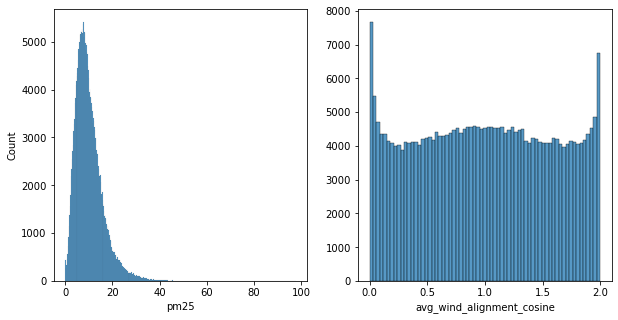

In [10]:
#columns = ['pm25', 'avg_wind_alignment_cosine']
columns = ['pm25', 'dist_school_to_ps_m']


# compute visits by patzip_year_month
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10, 5))

for idx, ax in enumerate(axes.flatten()):
    sb.histplot(
            df_all[columns[idx]],
            ax=ax
        )
    
    if idx in [0]:
        ax.set_ylabel('Count')
    else:
        ax.set_ylabel(' ')

``health outcomes``

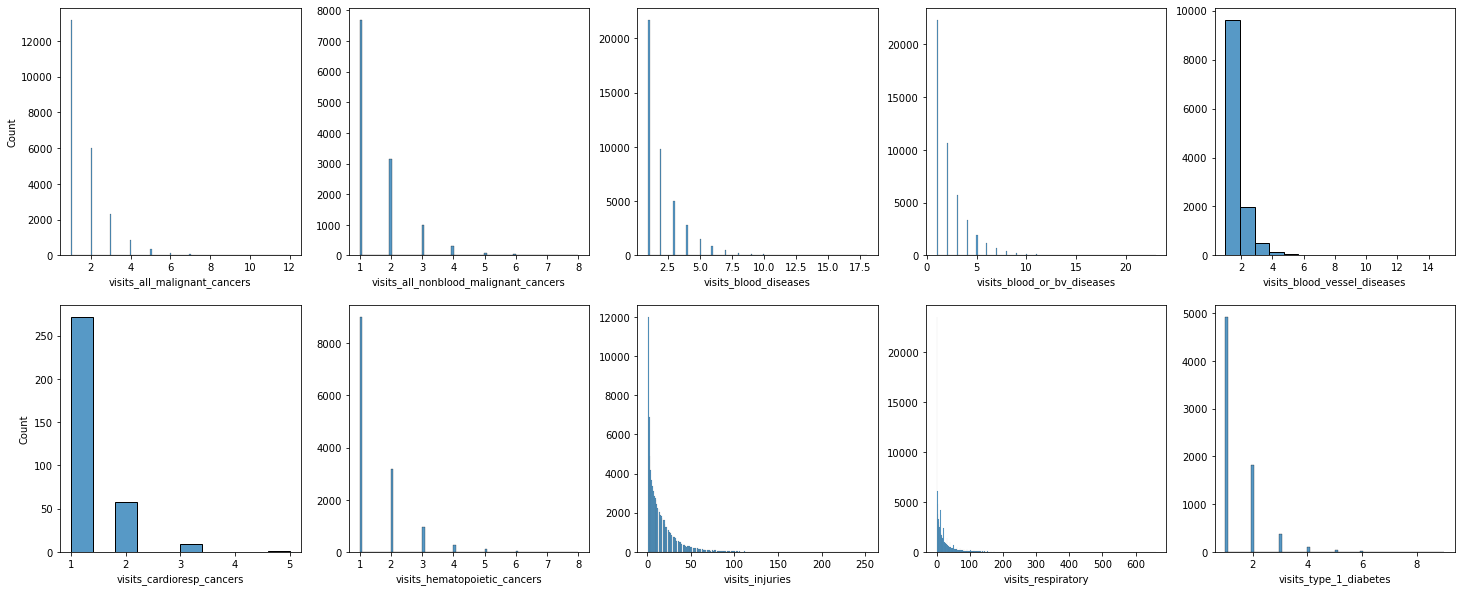

In [11]:
columns = df_h.columns[1:]

# compute visits by patzip_year_month
fig, axes = plt.subplots(2, 5, sharex=False, sharey=False, figsize=(25, 10)) #12

for idx, ax in enumerate(axes.flatten()):
    sb.histplot(
            df_all[columns[idx]],
            ax=ax
        )
    if idx in [0, 5]:
        ax.set_ylabel('Count')
    else:
        ax.set_ylabel(' ')

---
### Step 7: Analysis - linear modeling

In [ ]:
# before modeling, filter out outcomes before 2002
# if year < 2002, drop
df_all['year_h'] = df_all.patzip_year_month.str.split('-').str[1]
df_all = df_all[df_all.year_h.ge('2002')]
df_all.drop(columns='year_h', inplace=True)

``fit ols``

In [12]:
pm25_predictor_name = 'pm25_r6'

for col in df_h.columns[1:]:
    #fit_ols(df_all, col)
    fit_ols(df_all, col, pm25_predictor_name)

Outcome:  visits_all_malignant_cancers
-------------------------------------


,variable,coef,std err,[0.025,0.975]
0,pm25,0.004387,0.002731,-0.001101,0.009874
1,Intercept,1.398619,0.038417,1.321418,1.475821


Outcome:  visits_all_nonblood_malignant_cancers
-------------------------------------


,variable,coef,std err,[0.025,0.975]
0,pm25,-0.003172,0.002395,-0.007988,0.001644
1,Intercept,1.562228,0.037377,1.487077,1.637380


Outcome:  visits_blood_diseases
-------------------------------------


,variable,coef,std err,[0.025,0.975]
0,pm25,0.024416,0.007431,0.009482,0.039350
1,Intercept,0.966768,0.094832,0.776196,1.157341


Outcome:  visits_blood_or_bv_diseases
-------------------------------------


,variable,coef,std err,[0.025,0.975]
0,pm25,0.026531,0.009163,0.008128,0.044935
1,Intercept,0.777164,0.122581,0.530954,1.023375


Outcome:  visits_blood_vessel_diseases
-------------------------------------


,variable,coef,std err,[0.025,0.975]
0,pm25,0.000010,0.002915,-0.005851,0.005872
1,Intercept,0.776021,0.048262,0.678984,0.873058


Outcome:  visits_cardioresp_cancers
-------------------------------------


,variable,coef,std err,[0.025,0.975]
0,pm25,-0.037321,0.106178,-0.254818,0.180175
1,Intercept,1.994614,2.658706,-3.451499,7.440726


Outcome:  visits_hematopoietic_cancers
-------------------------------------


,variable,coef,std err,[0.025,0.975]
0,pm25,0.006120,0.001785,0.002531,0.009708
1,Intercept,1.632567,0.022994,1.586335,1.678799


Outcome:  visits_injuries
-------------------------------------


,variable,coef,std err,[0.025,0.975]
0,pm25,0.476477,0.152757,0.169805,0.783148
1,Intercept,-12.695251,1.819903,-16.348858,-9.041643


Outcome:  visits_respiratory
-------------------------------------


,variable,coef,std err,[0.025,0.975]
0,pm25,0.972369,0.249021,0.472439,1.472299
1,Intercept,-9.868843,3.686251,-17.269301,-2.468386


Outcome:  visits_type_1_diabetes
-------------------------------------


,variable,coef,std err,[0.025,0.975]
0,pm25,0.004629,0.003551,-0.002510,0.011767
1,Intercept,1.268440,0.057751,1.152324,1.384557


``fit first stage``

In [13]:
#df_all = fit_1st_stage(df_all, 'pm25', 'avg_wind_alignment_cosine')
df_all = fit_1st_stage(df_all, 'pm25', 'Izmy_v1_unnormed')
df_all = fit_1st_stage(df_all, 'pm25', 'Izmy_v2_nodist_unnormed')
df_all = fit_1st_stage(df_all, 'pm25', 'Izmy_v3_normed_D_and_TPY')
df_all = fit_1st_stage(df_all, 'pm25', 'Izmy_v4_nodist_normed_TPY')
df_all = fit_1st_stage(df_all, 'pm25', 'Izmy_v5_all_normed')


Outcome:  pm25
-------------------------------------


,variable,coef,std err,[0.025,0.975]
0,avg_wind_alignment_cosine,0.098112,0.053029,-0.008076,0.204300
1,Intercept,15.926150,0.054434,15.817147,16.035152


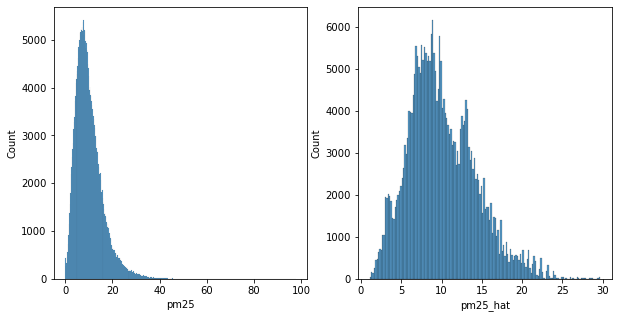

In [14]:
columns = ['pm25', 'pm25_hat']

# compute visits by patzip_year_month
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10, 5))

for idx, ax in enumerate(axes.flatten()):
    sb.histplot(
            df_all[columns[idx]],
            ax=ax
        )

First stage F-test:

Run an F test with our instrument to study the impact on the pm2.5. 

In [15]:
# get data into right model form
y, X_null = dmatrices('pm25 ~ 1', data=df_all, return_type='dataframe')
y, X_instrument = dmatrices('pm25 ~ 1 + avg_wind_alignment_cosine', data=df_all, return_type='dataframe')

fit_null = sm.OLS(y, X_null).fit()
fit_instrument = sm.OLS(y, X_instrument).fit()

anovaResults = anova_lm(fit_null, fit_instrument)
anovaResults

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,294896.0,1.034490e+07,0.0,NaN,NaN,NaN
1,294895.0,1.034337e+07,1.0,1530.248456,43.628194,3.977474e-11


``fit 2sls``

In [16]:
for col in df_h.columns[1:]:
    fit_2sls(df_all, col)

Outcome:  visits_all_malignant_cancers
-------------------------------------


,variable,coef,std err,[0.025,0.975]
0,pm25_hat,-0.405395,0.244000,-0.895731,0.084940
1,Intercept,7.948728,3.905241,0.100853,15.796604


Outcome:  visits_all_nonblood_malignant_cancers
-------------------------------------


,variable,coef,std err,[0.025,0.975]
0,pm25_hat,-0.698140,0.204491,-1.109297,-0.286983
1,Intercept,12.689687,3.273825,6.107221,19.272153


Outcome:  visits_blood_diseases
-------------------------------------


,variable,coef,std err,[0.025,0.975]
0,pm25_hat,-0.589757,0.478916,-1.552175,0.372662
1,Intercept,10.720163,7.667302,-4.687857,26.128183


Outcome:  visits_blood_or_bv_diseases
-------------------------------------


,variable,coef,std err,[0.025,0.975]
0,pm25_hat,-0.832232,0.563618,-1.964291,0.299828
1,Intercept,14.450721,9.019846,-3.666172,32.567614


Outcome:  visits_blood_vessel_diseases
-------------------------------------


,variable,coef,std err,[0.025,0.975]
0,pm25_hat,-0.151853,0.208285,-0.570638,0.266933
1,Intercept,3.202102,3.327449,-3.488182,9.892386


Outcome:  visits_cardioresp_cancers
-------------------------------------


,variable,coef,std err,[0.025,0.975]
0,pm25_hat,-0.816610,9.312862,-19.893142,18.259923
1,Intercept,12.742129,133.225536,-260.158010,285.642268


Outcome:  visits_hematopoietic_cancers
-------------------------------------


,variable,coef,std err,[0.025,0.975]
0,pm25_hat,-0.012257,0.173884,-0.361873,0.337359
1,Intercept,1.907400,2.780406,-3.682980,7.497780


Outcome:  visits_injuries
-------------------------------------


,variable,coef,std err,[0.025,0.975]
0,pm25_hat,-13.412940,5.855306,-25.167956,-1.657924
1,Intercept,207.705753,93.736116,19.522648,395.888858


Outcome:  visits_respiratory
-------------------------------------


,variable,coef,std err,[0.025,0.975]
0,pm25_hat,-14.686715,8.066454,-30.880797,1.507366
1,Intercept,239.635609,129.130842,-19.605373,498.876592


Outcome:  visits_type_1_diabetes
-------------------------------------


,variable,coef,std err,[0.025,0.975]
0,pm25_hat,-0.070618,0.178914,-0.430348,0.289112
1,Intercept,2.476124,2.868997,-3.292380,8.244629
